full train images (60000, 28, 28)
full train labels (60000,)
Loaded:
Keys: KeysView(NpzFile 'object' with keys: x_train, y_train, x_test, y_test)
  x_train: (50000, 28, 28) uint8
  y_train: (50000,) uint8
  x_valid : (10000, 28, 28) uint8
  y_valid : (10000,) uint8
  x_test : (10000, 28, 28) uint8
  y_test : (10000,) uint8
Number of classes: 10


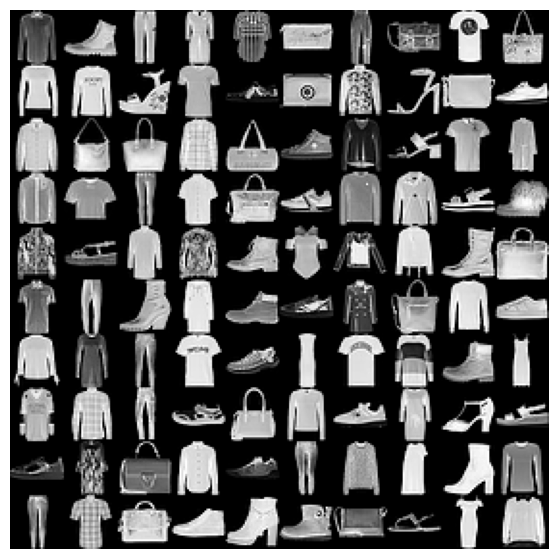

images shape: (100, 28, 28)
labels shape: (100,)


In [16]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
import urllib.request
import gzip
import numpy as np
from pathlib import Path

# Create data folder
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

# URLs for the original Fashion-MNIST gz files
base_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/"
files = {
    "train_images": "train-images-idx3-ubyte.gz",
    "train_labels": "train-labels-idx1-ubyte.gz",
    "test_images":  "t10k-images-idx3-ubyte.gz",
    "test_labels":  "t10k-labels-idx1-ubyte.gz",
}

def download_if_needed(filename):
    url = base_url + filename
    out_path = data_dir / filename
    if not out_path.exists():
        print("Downloading", url)
        urllib.request.urlretrieve(url, out_path)
    else:
        print("Already downloaded:", out_path)
    return out_path

def load_idx_images_gz(path_gz):
    with gzip.open(path_gz, "rb") as f:
        _magic = int.from_bytes(f.read(4), "big")   # magic
        n_images = int.from_bytes(f.read(4), "big") # count
        n_rows   = int.from_bytes(f.read(4), "big")
        n_cols   = int.from_bytes(f.read(4), "big")
        buf = f.read(n_images * n_rows * n_cols)
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(n_images, n_rows, n_cols)
        return data

def load_idx_labels_gz(path_gz):
    with gzip.open(path_gz, "rb") as f:
        _magic = int.from_bytes(f.read(4), "big")
        n_labels = int.from_bytes(f.read(4), "big")
        buf = f.read(n_labels)
        labels = np.frombuffer(buf, dtype=np.uint8)
        return labels

# Download all four files if missing
paths = {k: download_if_needed(v) for k, v in files.items()}

# Parse them into NumPy arrays
x_train_full = load_idx_images_gz(paths["train_images"])
y_train_full = load_idx_labels_gz(paths["train_labels"])
x_test_full  = load_idx_images_gz(paths["test_images"])
y_test_full  = load_idx_labels_gz(paths["test_labels"])


print("full train images", x_train_full.shape)
print("full train labels", y_train_full.shape)
# Create subsets: 50,000 for training, 10,000 for validation (from 60,000 train)
x_train = x_train_full[:50000]
y_train = y_train_full[:50000]

x_valid = x_train_full[50000:60000]
y_valid = y_train_full[50000:60000]

x_test = x_test_full
y_test = y_test_full

# Number of classes (should be 10 for Fashion-MNIST)
num_classes = int(np.unique(y_train).size)
print("Loaded:")
print("Keys:", keys)
print("  x_train:", x_train.shape, x_train.dtype) # (50000, 28, 28)
print("  y_train:", y_train.shape, y_train.dtype) # (50000,)
print("  x_valid :", x_valid.shape, x_valid.dtype) # (10000, 28, 28)
print("  y_valid :", y_valid.shape, y_valid.dtype) # (10000,)
print("  x_test :", x_test.shape, x_test.dtype) # (10000, 28, 28)
print("  y_test :", y_test.shape, y_test.dtype) # (10000,)
print("Number of classes:", num_classes)  # expected 10

# Visualize some examples from the training set first 100 images
n = x_train.shape[0]
idx = np.random.permutation(n)[:100]

images = x_train[idx]   # (100, 28, 28)
labels = y_train[idx]   # (100,)
# Plot a few MNIST examples

# Build a 10x10 grid using NumPy only
rows, columns = 10, 10
heighth, width = images.shape[1], images.shape[2]  # 28, 28
grid = np.zeros((rows * heighth, columns * width), dtype=images.dtype)

for i in range(rows * columns):
    r = i // columns
    c = i % columns
    grid[r*heighth:(r+1)*heighth, c*width:(c+1)*width] = images[i]

# Plot the grid
plt.figure(figsize=(7, 7))
plt.imshow(grid, cmap="gray")
plt.axis("off")
plt.show()

print("images shape:", images.shape)
print("labels shape:", labels.shape)


In [ ]:
""" 
from Utilisfunction import *
from Utilisfunction import FFNN, train_ffnn, accuracy, one_hot
# ============================================================
# Train & evaluate on Fashion-MNIST
# ============================================================

# Use all training/validation (you can slice to smaller subsets if needed)
X_train_np = x_train.astype(np.float32) / 255.0
y_train_np = y_train
X_valid_np = x_valid.astype(np.float32) / 255.0
y_valid_np = y_valid

#input_dim = 28 * 28
input_dim=X_train_np.shape[1]*X_train_np.shape[2]
print("Input dim:", input_dim)
num_classes = int(np.unique(y_train_np).size)
ffnn = FFNN(
    input_dim=input_dim,
    num_classes=num_classes,
    num_hidden_layers=2,
    n_hidden_units=128,
    activation="relu",
    loss="cross_entropy",
    learning_rate=0.001,
    l2_coeff=1e-4,
    weights_init="he",
    optimizer="adam",
)

history = train_ffnn(
    ffnn,
    X_train=X_train_np,
    y_train=y_train_np,
    X_valid=X_valid_np,
    y_valid=y_valid_np,
    num_epochs=15,
    batch_size=128,
    validation_every_steps=500
)

# Loss curves
plt.figure()
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["valid_loss"], label="valid loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("NumPy FFNN loss curves (Fashion-MNIST)")
plt.legend()
plt.show()

# Test evaluation
X_test_np = x_test.astype(np.float32) / 255.0
X_test_flat = X_test_np.reshape(X_test_np.shape[0], -1)
y_test_proba = ffnn.predict_proba(X_test_flat)
test_acc = accuracy(y_test_proba, y_test)
print(f"Test accuracy (NumPy FFNN): {test_acc:.4f}")

# Confusion matrix
num_classes = int(np.unique(y_test).size)
y_pred_labels = np.argmax(y_test_proba, axis=1)
conf_mat = np.zeros((num_classes, num_classes), dtype=int)
for yt, yp in zip(y_test, y_pred_labels):
    conf_mat[int(yt), int(yp)] += 1

print("Confusion matrix (rows=true, cols=pred):")
print(conf_mat)
 """
from Utilisfunction import *
from Utilisfunction import FFNN, train_ffnn, accuracy, one_hot

# ============================================================
# Train & evaluate on Fashion-MNIST  (slightly tuned)
# ============================================================

# 1) Normalize inputs a bit better
X_train_np = x_train.astype(np.float32) / 255.0
X_valid_np = x_valid.astype(np.float32) / 255.0
X_test_np  = x_test.astype(np.float32) / 255.0

mean = X_train_np.mean(axis=0, keepdims=True)
std  = X_train_np.std(axis=0, keepdims=True) + 1e-7

X_train_np = (X_train_np - mean) / std
X_valid_np = (X_valid_np - mean) / std
X_test_np  = (X_test_np - mean) / std

y_train_np = y_train
y_valid_np = y_valid

# 2) Model hyperparameters
input_dim = X_train_np.shape[1] * X_train_np.shape[2]
print("Input dim:", input_dim)
num_classes = int(np.unique(y_train_np).size)

ffnn = FFNN(
    input_dim=input_dim,
    num_classes=num_classes,
    num_hidden_layers=2,
    n_hidden_units=256,          # a bit larger
    activation="relu",
    loss="cross_entropy",
    learning_rate=0.001,
    l2_coeff=1e-3,               # slightly stronger regularization
    weights_init="he",
    optimizer="adam",
)

# 3) Train
history = train_ffnn(
    ffnn,
    X_train=X_train_np,
    y_train=y_train_np,
    X_valid=X_valid_np,
    y_valid=y_valid_np,
    num_epochs=20,               # allow more epochs
    batch_size=128,
    validation_every_steps=500
)

# 4) Loss curves
plt.figure()
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["valid_loss"], label="valid loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("NumPy FFNN loss curves (Fashion-MNIST)")
plt.legend()
plt.show()

# 5) Test evaluation
X_test_flat = X_test_np.reshape(X_test_np.shape[0], -1)
y_test_proba = ffnn.predict_proba(X_test_flat)
test_acc = accuracy(y_test_proba, y_test)
print(f"Test accuracy (NumPy FFNN): {test_acc:.4f}")

# Confusion matrix
num_classes = int(np.unique(y_test).size)
y_pred_labels = np.argmax(y_test_proba, axis=1)
conf_mat = np.zeros((num_classes, num_classes), dtype=int)
for yt, yp in zip(y_test, y_pred_labels):
    conf_mat[int(yt), int(yp)] += 1

print("Confusion matrix (rows=true, cols=pred):")
print(conf_mat)